### Model Training - Linear Regression

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from datetime import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score

In [34]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [35]:
data_path = Path("../data/processed/earthquake_data_tsunami_scaled.csv")
data_df = pd.read_csv(data_path)

In [36]:
data_df.head()

,magnitude,cdi,mmi,sig,depth,distance_to_coast_km,nst,dmin,gap,latitude,longitude,Year,Month,tsunami,month_number
0,-0.454008,0.366134,-0.750815,0.042117,-1.273282,-0.641182,0.0,1.319,19.0,-39.3264,-74.9067,2020.0,12.0,0.0,252.0
1,0.480596,1.147295,0.682949,1.802154,-0.271551,-0.641182,0.0,1.518,18.0,37.8973,26.7953,2020.0,10.0,0.0,250.0
2,1.464696,1.387524,0.682949,1.472781,0.067414,-0.641182,0.0,0.230,36.0,54.6620,-159.6750,2020.0,10.0,0.0,250.0
3,0.215003,-1.381760,-2.007214,-0.349174,-1.273282,-0.641182,0.0,11.255,16.0,0.9604,-26.8332,2020.0,9.0,0.0,249.0
4,-1.366553,0.638393,-0.053959,-1.035334,-0.610675,-0.641182,0.0,0.388,49.0,-27.9285,-71.3937,2020.0,9.0,0.0,249.0


In [37]:
features_to_exclude = ['tsunami']
X = data_df.drop(columns=[col for col in features_to_exclude if col in data_df.columns])
y = data_df['tsunami']

Stratified K Fold is used to prevent the class imbalance and preserve the class ratio in every fold

In [38]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [39]:
# Create F2 scorer (emphasizes recall - minimizing false negatives)
f2_scorer = make_scorer(fbeta_score, beta=2.0, zero_division=0)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'f2': f2_scorer,
    'roc_auc': make_scorer(roc_auc_score)
}

 ### Pipeline 
Pipeline ensures transformations (scaling) are applied correctly inside each fold
### StandardScaler 
Using StandardScaler normalizes features (essential for logistic regression)
### Logistic Regression
Class weight is set to balanced in order to compensate for class imbalance
Iteration ensures convergence


In [40]:
pipeline = Pipeline([
    ('classifier', LogisticRegression(
        class_weight='balanced',  
        max_iter=5000,
        random_state=42,
        solver='lbfgs'
    ))
])

In [41]:
cv_results = cross_validate(
    pipeline, X, y, 
    cv=skf, 
    scoring=scoring, 
    return_train_score=True,
    n_jobs=-1
)

Checking for overfitting by comparing train and test scores

In [42]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results_summary = []

for metric in metrics:
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']
    
    results_summary.append({
        'Metric': metric.upper(),
        'Train Mean': f"{train_scores.mean():.4f}",
        'Train Std': f"{train_scores.std():.4f}",
        'Test Mean': f"{test_scores.mean():.4f}",
        'Test Std': f"{test_scores.std():.4f}"
    })

results_df = pd.DataFrame(results_summary)

In [43]:
results_df

,Metric,Train Mean,Train Std,Test Mean,Test Std
0,ACCURACY,0.7900,0.0060,0.7800,0.0253
1,PRECISION,0.5145,0.0094,0.5012,0.0401
2,RECALL,0.8133,0.0139,0.7987,0.0688
3,F1,0.6302,0.0086,0.6149,0.0432
4,ROC_AUC,0.7984,0.0065,0.7867,0.0356


In [44]:
for metric in metrics:
    train_mean = cv_results[f'train_{metric}'].mean()
    test_mean = cv_results[f'test_{metric}'].mean()
    gap = train_mean - test_mean
    print(f"{metric.upper():12} - Train: {train_mean:.4f}, Test: {test_mean:.4f}, Gap: {gap:+.4f}")

ACCURACY     - Train: 0.7900, Test: 0.7800, Gap: +0.0100
PRECISION    - Train: 0.5145, Test: 0.5012, Gap: +0.0134
RECALL       - Train: 0.8133, Test: 0.7987, Gap: +0.0146
F1           - Train: 0.6302, Test: 0.6149, Gap: +0.0153
ROC_AUC      - Train: 0.7984, Test: 0.7867, Gap: +0.0116


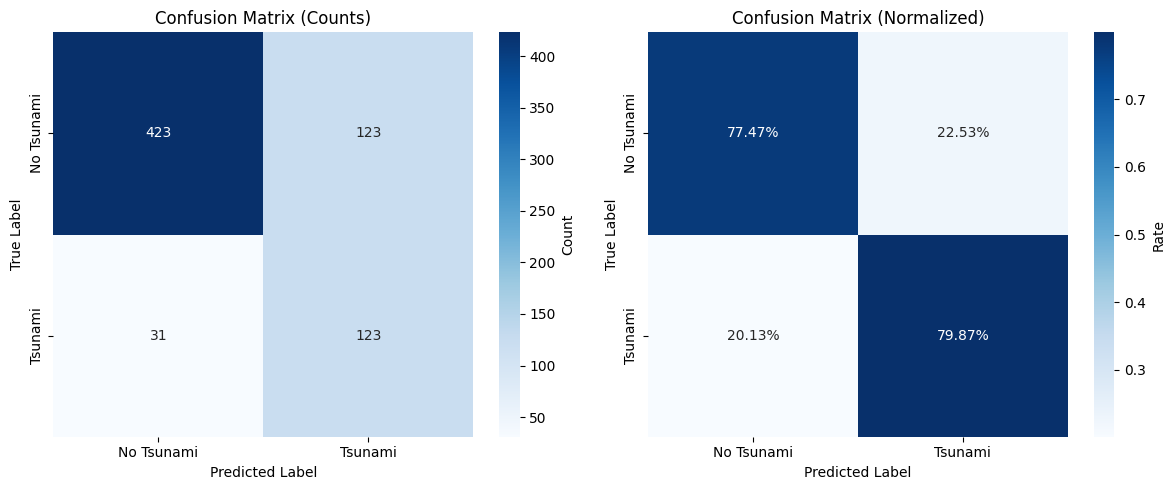


Confusion Matrix Analysis:
True Positives (TP): 123
False Positives (FP): 123
True Negatives (TN): 423
False Negatives (FN): 31

False Negative Rate: 0.2013 (20.13%)
False Negatives as % of total: 4.43%


In [45]:
y_pred_cv = cross_val_predict(pipeline, X, y, cv=skf, n_jobs=-1)

cm = confusion_matrix(y, y_pred_cv)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticklabels(['No Tsunami', 'Tsunami'])
axes[0].set_yticklabels(['No Tsunami', 'Tsunami'])

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1], cbar_kws={'label': 'Rate'})
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_xticklabels(['No Tsunami', 'Tsunami'])
axes[1].set_yticklabels(['No Tsunami', 'Tsunami'])

plt.tight_layout()
plt.show()

# Calculate false negative rate (critical for tsunami detection)
# False negatives = cm[1,0] (actual tsunami but predicted as no tsunami)
# False negative rate = FN / (FN + TP) = cm[1,0] / (cm[1,0] + cm[1,1])
fn_rate = cm[1,0] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0.0
fn_percentage = (cm[1,0] / cm.sum()) * 100  # FN as percentage of total samples

print(f"\nConfusion Matrix Analysis:")
print(f"True Positives (TP): {cm[1,1]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"True Negatives (TN): {cm[0,0]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"\nFalse Negative Rate: {fn_rate:.4f} ({fn_rate*100:.2f}%)")
print(f"False Negatives as % of total: {fn_percentage:.2f}%")

In [46]:
results_dir = Path("../models")
results_dir.mkdir(parents=True, exist_ok=True)
results_csv = results_dir / "model_results.csv"

In [47]:
# Calculate F2 score from cross-validation results
test_f2 = cv_results["test_f2"].mean() if "test_f2" in cv_results else fbeta_score(y, y_pred_cv, beta=2.0, zero_division=0)
train_f2 = cv_results["train_f2"].mean() if "train_f2" in cv_results else fbeta_score(y, cross_val_predict(pipeline, X, y, cv=skf, n_jobs=-1, method='predict'), beta=2.0, zero_division=0)

logistic_results = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model": "Logistic Regression",
    "cv_splits": skf.get_n_splits(),
    "scaler": "StandardScaler",
    "class_weight": "balanced",
    "test_accuracy": cv_results["test_accuracy"].mean(),
    "test_precision": cv_results["test_precision"].mean(),
    "test_recall": cv_results["test_recall"].mean(),
    "test_f1": cv_results["test_f1"].mean(),
    "test_f2": test_f2,
    "test_roc_auc": cv_results["test_roc_auc"].mean(),
    "train_accuracy": cv_results["train_accuracy"].mean(),
    "train_precision": cv_results["train_precision"].mean(),
    "train_recall": cv_results["train_recall"].mean(),
    "train_f1": cv_results["train_f1"].mean(),
    "train_f2": train_f2,
    "train_roc_auc": cv_results["train_roc_auc"].mean(),
    "train_test_gap_accuracy": cv_results["train_accuracy"].mean() - cv_results["test_accuracy"].mean(),
    "false_negative_rate": fn_rate,
    "false_negative_percentage": fn_percentage,
    "notes": ""
}

In [48]:
new_results_df = pd.DataFrame([logistic_results])
if results_csv.exists():
    existing_results = pd.read_csv(results_csv)
    model_comparison = pd.concat([existing_results, new_results_df], ignore_index=True)
    model_comparison.to_csv(results_csv, index=False)
else:
    new_results_df.to_csv(results_csv, index=False)
    
new_results_df.T

,0
timestamp,2025-11-17 03:19:14
model,Logistic Regression
cv_splits,5
scaler,StandardScaler
class_weight,balanced
test_accuracy,0.78
test_precision,0.501163
test_recall,0.79871
test_f1,0.614865
test_f2,0.71291


## Model 1: Logistic Regression Results

**Key Findings:**
- **Test Accuracy**: 0.78 (78.0%)
- **Test Precision**: 0.5012 (50.12%)
- **Test Recall**: 0.7987 (79.87%) - Successfully detects tsunamis
- **Test F1 Score**: 0.6149 (61.49%)
- **Test F2 Score**: 0.7129 (71.29%) - Emphasizes recall (minimizing false negatives)
- **Test ROC-AUC**: 0.7867 (78.67%) - Moderate class separation
- **False Negative Rate**: 20.13% - Critical metric for tsunami detection
- **False Negatives**: 4.43% of total samples
- **Train/Test Gap (Accuracy)**: 0.01 (1.0%) - No overfitting, train/test gaps all <1.5%

**Next Steps:**
- Try tree-based models that can capture nonlinear interactions
- Address precision-recall trade-off (high recall but lower precision)